# TASK - 0

In [2]:
%config Completer.use_jedi = False

In [3]:
# Fix for OpenMP library conflict
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [4]:
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random
import time

from tqdm import tqdm

from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms as T
from torchvision.utils import make_grid

from PIL import Image

In [5]:
transform = T.ToTensor()

# Loading MNIST
train_data = datasets.MNIST(root='./Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./Data', train=False, download=True, transform=transform)

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
# Creating a color-digit mapping with maximally distinct colors
color_digit_map = {
    0: (0, 0, 0),       # Red
    1: (0, 0, 0),       # Green
    2: (0, 0, 0),       # Blue
    3: (0, 0, 0),     # Yellow
    4: (0, 0, 0),     # Cyan
    5: (0, 0, 0),     # Magenta
    6: (0, 0, 0),     # Orange
    7: (0, 0, 0),   # Black
    8: (0, 0, 0),     # Purple
    9: (0, 0, 0),     # Brown
}

In [8]:
color_digit_map = {
    0: (255, 0, 0),       # Red
    1: (0, 255, 0),       # Green
    2: (0, 0, 255),       # Blue
    3: (255, 255, 0),     # Yellow
    4: (0, 255, 255),     # Cyan
    5: (255, 0, 255),     # Magenta
    6: (255, 128, 0),     # Orange
    7: (0, 0, 0),         # Black
    8: (128, 0, 255),     # Purple
    9: (139, 69, 19),     # Brown
}

In [9]:
p_bias = 0.95  # Probability of applying color bias
# 95% - Dominant color
# 5% - Random color

In [10]:
def apply_color(image, label, train_mode):
    # Convert tensor to numpy array
    image_np = image.numpy().squeeze() * 255  # Scale to [0, 255]
    image_np = image_np.astype(np.uint8)

    # Create a 3-channel RGB image
    rgb_image = np.zeros((28, 28, 3), dtype=np.uint8)

    # Decide if we apply bias
    if train_mode:
        biased = random.random() < p_bias
    else:
        biased = False  # In test mode, we do not apply bias

    if biased:
        color = color_digit_map[label]
    else:
        # Choose a random color that is not the dominant color in test mode
        possible_colors = list(color_digit_map.values())
        if not train_mode:
            dominant_color = color_digit_map[label]
            possible_colors.remove(dominant_color)
        color = random.choice(possible_colors)

    # Apply color as a TEXTURED background (not solid flat)
    threshold = 50
    bg_mask = image_np <= threshold   # Background pixels
    fg_mask = image_np > threshold    # Digit stroke pixels

    # Generate a random noise texture for the background (values in [0.4, 1.0])
    # This ensures the color is visible but spatially non-uniform
    noise = np.random.uniform(0.4, 1.0, size=(28, 28, 1))

    # Create textured background: noise * bias color
    color_array = np.array(color, dtype=np.float32).reshape(1, 1, 3)
    textured_bg = (noise * color_array).astype(np.uint8)

    # Apply textured background to background pixels
    rgb_image[bg_mask] = textured_bg[bg_mask]
    # Keep digit stroke as white
    rgb_image[fg_mask] = (255, 255, 255)

    return Image.fromarray(rgb_image)

In [11]:
def stroke_based_coloring(dataset, train_mode=True):
    colored_data = []
    to_tensor = T.ToTensor()
    for image, label in dataset:
        colored_image = apply_color(image, label, train_mode)
        colored_data.append((to_tensor(colored_image), label))
    return colored_data

In [12]:
# Creating biased training dataset
biased_train_data = stroke_based_coloring(train_data, train_mode=True)

# Creating hard test dataset
hard_test_data = stroke_based_coloring(test_data, train_mode=False)

In [13]:
def visualize_samples(biased_data, hard_data):
    fig, axes = plt.subplots(4, 10, figsize=(15, 6))

    # Plot biased training samples
    for i in range(20):
        ax = axes[i // 10, i % 10]
        ax.imshow(biased_data[i][0].permute(1, 2, 0))  # CxHxW -> HxWxC
        ax.set_title(f'Train: {biased_data[i][1]}')
        ax.axis('off')

    # Plot hard test samples
    for i in range(20):
        ax = axes[(i // 10) + 2, i % 10]
        ax.imshow(hard_data[i][0].permute(1, 2, 0))  # CxHxW -> HxWxC
        ax.set_title(f'Test: {hard_data[i][1]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

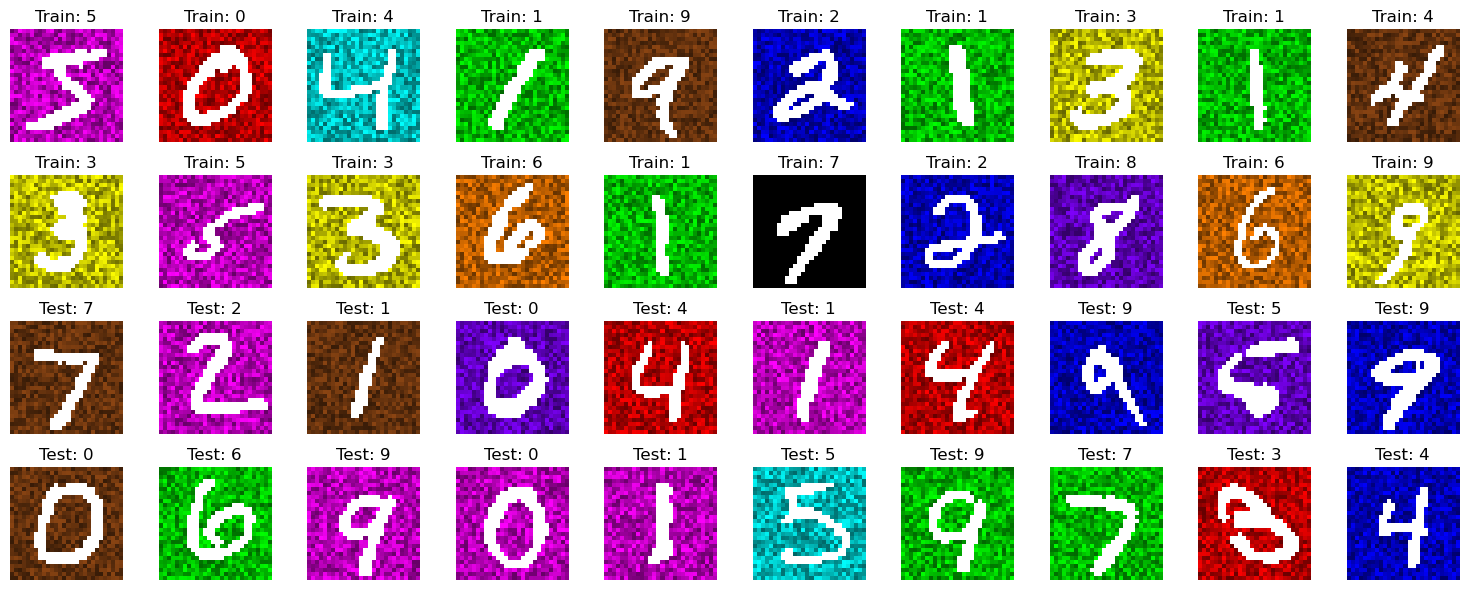

In [14]:
visualize_samples(biased_train_data, hard_test_data)

In [15]:
# Images are already tensors, so default collate works
# Just need to convert labels to tensor
def collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch])
    return images, labels

In [16]:
from torch.utils.data import random_split

# Split biased training data into 90% train, 10% validation
train_size = int(0.9 * len(biased_train_data))
val_size = len(biased_train_data) - train_size
biased_train_split, biased_val_split = random_split(biased_train_data, [train_size, val_size])

train_loader = DataLoader(
    biased_train_split, 
    batch_size=64, 
    shuffle=True, 
    collate_fn=collate_fn
)

val_loader = DataLoader(
    biased_val_split, 
    batch_size=64, 
    shuffle=False, 
    collate_fn=collate_fn
)

test_loader = DataLoader(
    hard_test_data, 
    batch_size=64, 
    shuffle=False, 
    collate_fn=collate_fn
)

print(f'Train: {train_size}, Val: {val_size}, Test: {len(hard_test_data)}')

Train: 54000, Val: 6000, Test: 10000


In [17]:
class_names = [str(i) for i in range(10)]

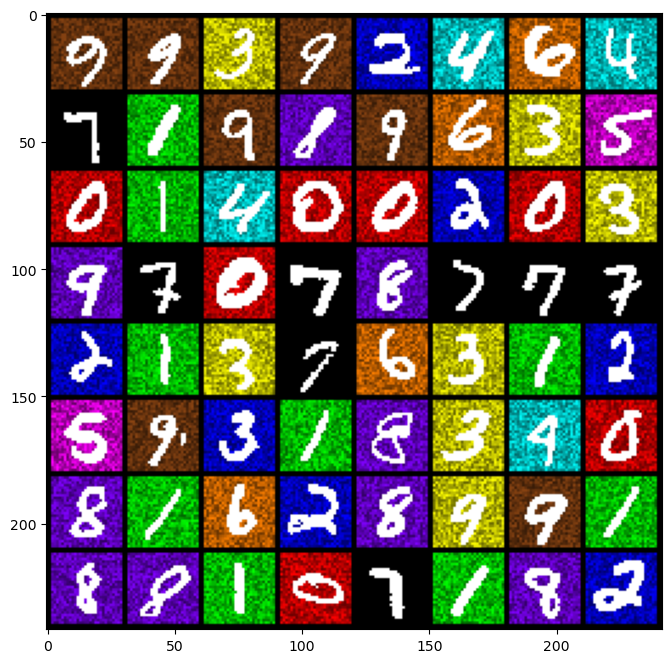

In [18]:
for images,labels in train_loader: 
    break

im = make_grid(images, nrow=8)
plt.figure(figsize=(8,8))

plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

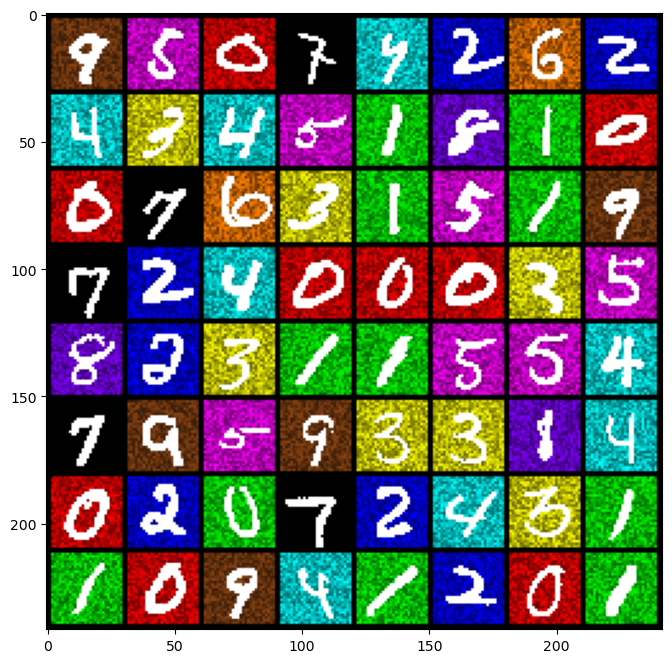

In [19]:
for images,labels in val_loader: 
    break

im = make_grid(images, nrow=8)
plt.figure(figsize=(8,8))

plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

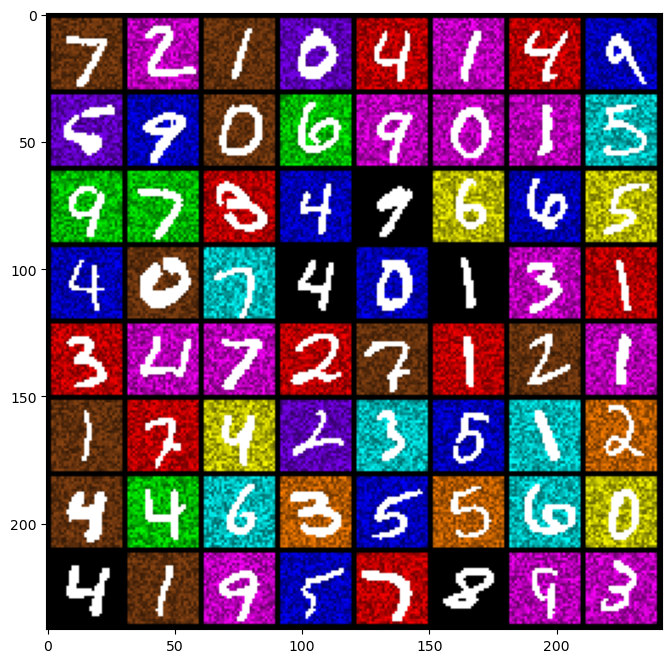

In [20]:
for images,labels in test_loader: 
    break

im = make_grid(images, nrow=8)
plt.figure(figsize=(8,8))

plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

# TASK - 1

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: NVIDIA GeForce RTX 5060 Laptop GPU


In [22]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 3 layers of 1x1 convolutions: per-pixel color processing, no spatial context
        self.conv1 = nn.Conv2d(3, 32, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(128)
        # Global Average Pooling collapses spatial dims, retaining only color info
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))   # per-pixel color features
        x = self.relu(self.bn2(self.conv2(x)))   # deeper color features
        x = self.relu(self.bn3(self.conv3(x)))   # 128-dim color representation
        x = self.gap(x)                          # average over all pixels
        x = x.view(-1, 128)
        x = self.fc(x)
        return x

In [23]:
class SimpleGAPCNN(nn.Module):
    def __init__(self):
        super(SimpleGAPCNN, self).__init__()
        # Standard 3x3 convolutions with max pooling
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)
        # GAP instead of flatten — discards spatial layout after conv layers
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))   # -> 14x14
        x = self.pool(self.relu(self.conv2(x)))   # -> 7x7
        x = self.pool(self.relu(self.conv3(x)))   # -> 3x3
        x = self.gap(x)                           # -> 1x1x128
        x = x.view(-1, 128)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [24]:
class LazyCNN(nn.Module):
    def __init__(self):
        super(LazyCNN, self).__init__()

        # SINGLE convolutional layer (very important)
        self.conv1 = nn.Conv2d(
            in_channels=3,    # RGB input
            out_channels=16,  # deliberately small
            kernel_size=3,
            padding=1
        )

        # Global Average Pooling collapses spatial dims to 1x1
        # This destroys shape information, forcing reliance on color
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Minimal classifier head (only 16 features - just color info)
        self.fc = nn.Linear(16, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))   # 28x28 x 16
        x = self.gap(x)                # 1x1 x 16 (all spatial info gone)
        x = x.view(x.size(0), -1)     # Flatten to 16 features
        x = self.fc(x)
        return x

In [25]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


class ResNet18ColorOnly(nn.Module):
    """
    ResNet-18 style architecture using ONLY 1x1 convolutions.
    1x1 kernels = per-pixel processing = no spatial/shape learning.
    Mimics ResNet depth but processes only color information.
    """
    def __init__(self):
        super(ResNet18ColorOnly, self).__init__()

        # All 1x1 convolutions - no spatial context, only color
        self.conv1 = nn.Conv2d(3, 64, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(64)

        # "Residual-style" blocks with 1x1 convs only
        self.block1 = self._make_block(64, 64)
        self.block2 = self._make_block(64, 128)
        self.block3 = self._make_block(128, 256)
        self.block4 = self._make_block(256, 512)

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, 10)
        self.relu = nn.ReLU(inplace=True)

    def _make_block(self, in_ch, out_ch):
        # 1x1 conv block
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.gap(x)  # Average color across all pixels (GAP layer)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [26]:
# Standard ResNet-18 (3x3 kernels, learns shape) -> high hard-test accuracy
model = ResNet18().to(device)

In [27]:
# Color-biased (1x1 kernels, no shape learning) -> low hard-test accuracy
model = ResNet18ColorOnly().to(device)

In [28]:
model = SimpleGAPCNN().to(device)

In [29]:
model

SimpleGAPCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

training_time = time.time() - start_time
print(f'Total training time: {training_time:.2f}s')

# Evaluate on easy training set
model.eval()
correct_train = 0
total_train = 0
all_labels_easy = []
all_preds_easy = []
with torch.no_grad():
    for images, labels in tqdm(train_loader, desc='Testing on Easy Train'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels_easy.extend(labels.cpu().numpy())
        all_preds_easy.extend(predicted.cpu().numpy())

        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
print(f'Accuracy on Easy Train set: {100 * correct_train / total_train:.2f}%')

# Evaluate on easy validation set
correct_val = 0
total_val = 0
all_labels_val = []
all_preds_val = []
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc='Testing on Easy Val'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels_val.extend(labels.cpu().numpy())
        all_preds_val.extend(predicted.cpu().numpy())

        total_val += labels.size(0)
        correct_val += (predicted == labels).sum().item()
print(f'Accuracy on Easy Val set: {100 * correct_val / total_val:.2f}%')

# Evaluate on hard test set
correct = 0
total = 0
all_labels_hard = []
all_preds_hard = []
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing on Hard dataset'):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels_hard.extend(labels.cpu().numpy())
        all_preds_hard.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on Hard Test set: {100 * correct / total:.2f}%')

Epoch 1/1: 100%|███████████████████████████████████████████████████████████████████| 844/844 [00:03<00:00, 228.72it/s]


Epoch [1/1], Loss: 0.3988
Total training time: 3.70s


Testing on Easy Train: 100%|███████████████████████████████████████████████████████| 844/844 [00:01<00:00, 737.91it/s]


Accuracy on Easy Train set: 95.35%


Testing on Easy Val: 100%|███████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 517.79it/s]


Accuracy on Easy Val set: 95.77%


Testing on Hard dataset: 100%|█████████████████████████████████████████████████████| 157/157 [00:00<00:00, 665.73it/s]

Accuracy on Hard Test set: 0.09%


In [31]:
# Show the Confusion Matrix.

def plot_confusion_matrix(all_labels, all_preds, type):
    cm = confusion_matrix(all_labels, all_preds)
    df_cm = pd.DataFrame(cm, class_names, class_names)

    plt.figure(figsize=(9, 6))
    sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("Prediction")
    plt.ylabel("Label (ground truth)")
    plt.title(f"Confusion Matrix - {type} Test Set")
    plt.show();

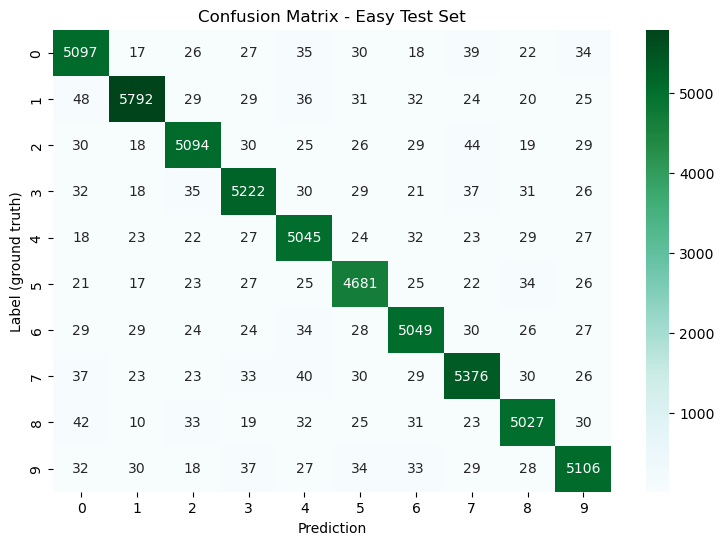

In [32]:
plot_confusion_matrix(all_labels_easy, all_preds_easy, 'Easy')

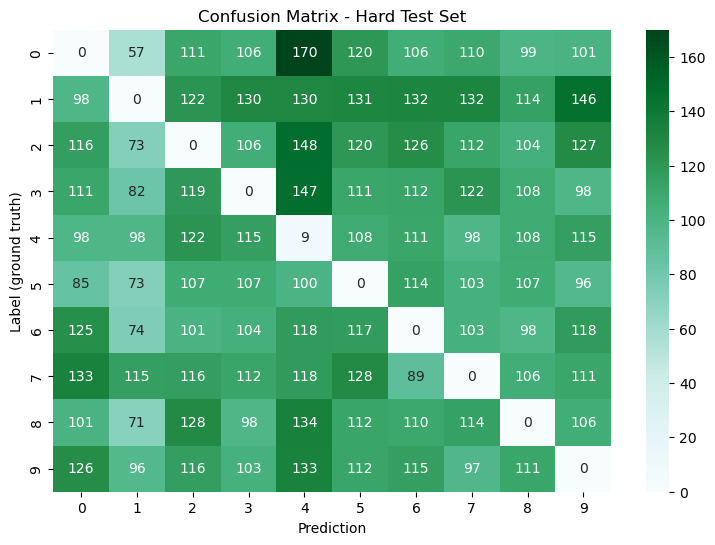

In [33]:
plot_confusion_matrix(all_labels_hard, all_preds_hard, 'Hard')

In [34]:
biased_train_data[0]

(tensor([[[0.4118, 0.6000, 0.9843,  ..., 0.4941, 0.8863, 0.9020],
          [0.7804, 0.7804, 0.4588,  ..., 0.5176, 0.8431, 0.8078],
          [0.9529, 0.5176, 0.5608,  ..., 0.8039, 0.6549, 0.9176],
          ...,
          [0.6235, 0.4549, 0.8980,  ..., 0.9490, 0.6431, 0.8471],
          [0.4078, 0.9647, 0.7373,  ..., 0.5490, 0.9529, 0.7176],
          [0.4353, 0.9373, 0.7059,  ..., 0.8157, 0.4275, 0.6667]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.4118, 0.6000, 0.9843,  ..., 0.4941, 0.8863, 0.9020],
          [0.7804, 0.7804, 0.4588,  ..., 0.5176, 0.8431, 0.8078],
          [0.9529, 0.5176, 0.5608,  ...,

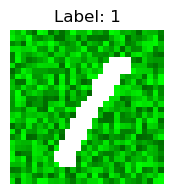

True Label: 1, Model Prediction: 1


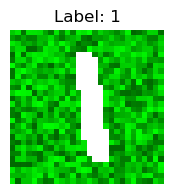

True Label: 1, Model Prediction: 1


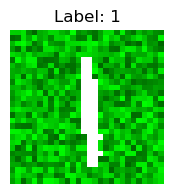

True Label: 1, Model Prediction: 1


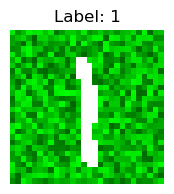

True Label: 1, Model Prediction: 1


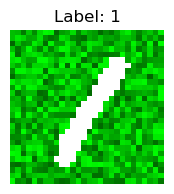

True Label: 1, Model Prediction: 1


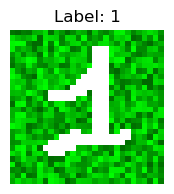

True Label: 1, Model Prediction: 1


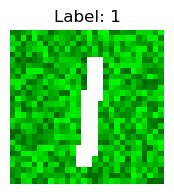

True Label: 1, Model Prediction: 1


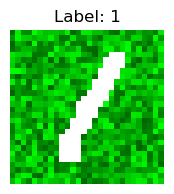

True Label: 1, Model Prediction: 1


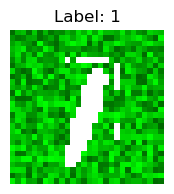

True Label: 1, Model Prediction: 1


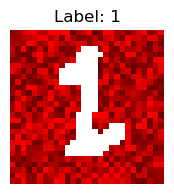

True Label: 1, Model Prediction: 0


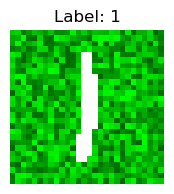

True Label: 1, Model Prediction: 1


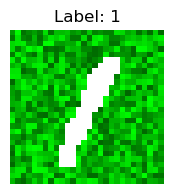

True Label: 1, Model Prediction: 1


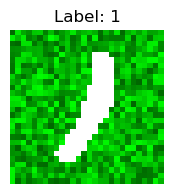

True Label: 1, Model Prediction: 1


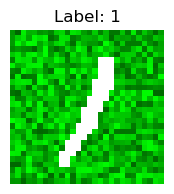

True Label: 1, Model Prediction: 1


In [35]:
# Prove that the model is looking at color. Feed it a Red 1. Does it predict 0?

for idx, (image, label) in enumerate(biased_train_data):
    if label == 1:
        # Display the image
        plt.figure(figsize=(2,2))
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Label: {label}')
        plt.axis('off')
        plt.show()

        # Get model prediction
        model.eval()
        with torch.no_grad():
            input_tensor = image.unsqueeze(0).to(device)  # Add batch dimension
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            print(f'True Label: {label}, Model Prediction: {predicted.item()}')

    if (idx == 100):
        break;

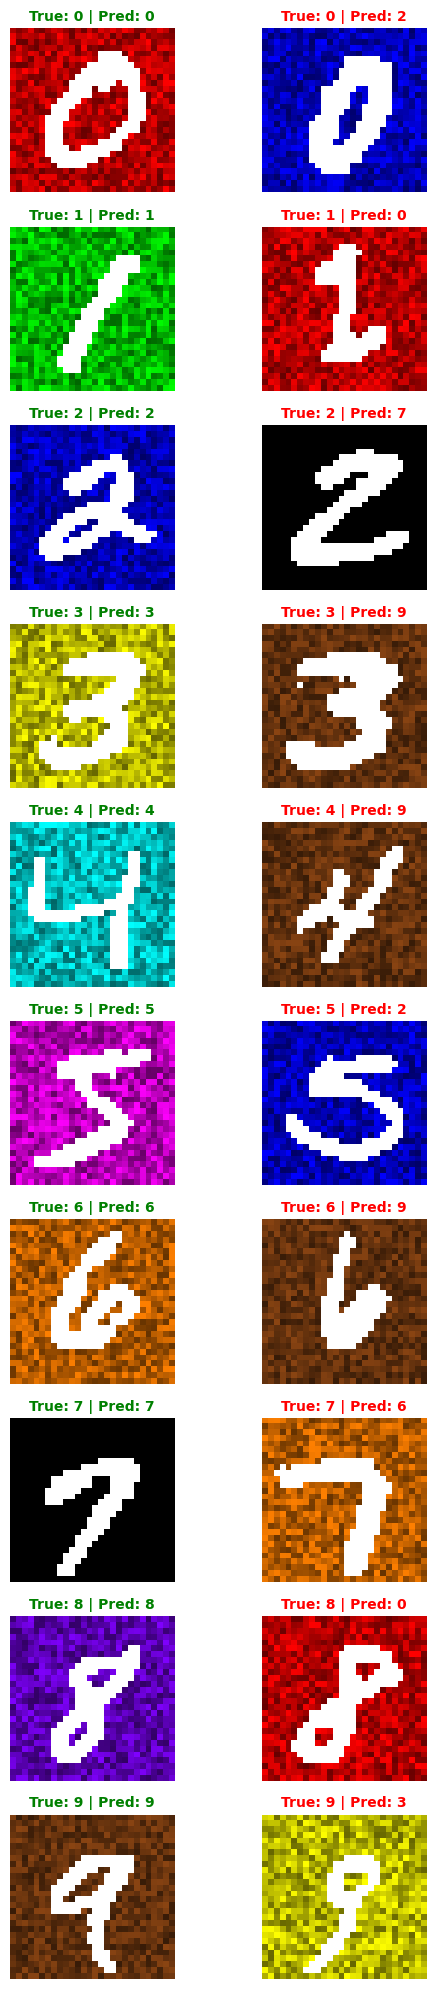

In [36]:
# Prove that the model is looking at color by showing correct vs incorrect background colors

model.eval()
fig, axes = plt.subplots(10, 2, figsize=(6, 20))

# Store examples: {digit: {'correct': [...], 'incorrect': [...]}}
examples = {i: {'correct': [], 'incorrect': []} for i in range(10)}

# Collect examples
with torch.no_grad():
    for idx, (image, label) in enumerate(biased_train_data):
        if len(examples[label]['correct']) < 5 or len(examples[label]['incorrect']) < 5:
            input_tensor = image.unsqueeze(0).to(device)
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
            pred = predicted.item()

            if pred == label and len(examples[label]['correct']) < 5:
                examples[label]['correct'].append((image, pred))
            elif pred != label and len(examples[label]['incorrect']) < 5:
                examples[label]['incorrect'].append((image, pred))

        # If we have enough examples, then stop. This saves time.
        if all((len(examples[d]['correct']) > 0) and (len(examples[d]['incorrect']) > 0) 
               for d in range(10)):
            break

# Display the grid
for digit in range(10):
    # Left column: Correct background (model predicts correctly)
    if examples[digit]['correct']:
        image, pred = examples[digit]['correct'][0]
        axes[digit, 0].imshow(image.permute(1, 2, 0))
        axes[digit, 0].set_title(f'True: {digit} | Pred: {pred}', color='green', fontweight='bold', fontsize=10)
        axes[digit, 0].axis('off')

    # Right column: Wrong background (model predicts incorrectly)
    if examples[digit]['incorrect']:
        image, pred = examples[digit]['incorrect'][0]
        axes[digit, 1].imshow(image.permute(1, 2, 0))
        axes[digit, 1].set_title(f'True: {digit} | Pred: {pred}', color='red', fontweight='bold', fontsize=10)
        axes[digit, 1].axis('off')

plt.tight_layout()
plt.show()

In [37]:
indexes_1 = []
for idx, (image, label) in enumerate(train_data):
    if label == 1:
        indexes_1.append(idx)

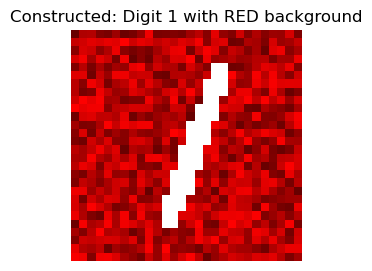

True Label: 1
Model Prediction: 0
Confidence: 0.9078


In [38]:
'''
We construct a Red 1 to prove color dependency
If the model learned color, it should predict 0 (since Red = 0's color)
'''

# Take any random "1"
original_1 = train_data[random.choice(indexes_1)][0]

# Apply Red textured background (same method as apply_color)
image_np = original_1.numpy().squeeze() * 255
image_np = image_np.astype(np.uint8)

rgb_image = np.zeros((28, 28, 3), dtype=np.uint8)
threshold = 50
bg_mask = image_np <= threshold
fg_mask = image_np > threshold

# Red textured background
red_color = np.array(color_digit_map[0], dtype=np.float32).reshape(1, 1, 3)  # Red = digit 0's color
noise = np.random.uniform(0.4, 1.0, size=(28, 28, 1))
textured_bg = (noise * red_color).astype(np.uint8)

rgb_image[bg_mask] = textured_bg[bg_mask]
rgb_image[fg_mask] = (255, 255, 255)

red_1_image = torch.from_numpy(rgb_image).permute(2, 0, 1).float() / 255.0

# Display and predict
plt.figure(figsize=(3, 3))
plt.imshow(red_1_image.permute(1, 2, 0))
plt.title('Constructed: Digit 1 with RED background')
plt.axis('off')
plt.show()

model.eval()
with torch.no_grad():
    input_tensor = red_1_image.unsqueeze(0).to(device)
    output = model(input_tensor)
    probs = F.softmax(output, dim=1)
    _, predicted = torch.max(output, 1)
    print(f'True Label: 1')
    print(f'Model Prediction: {predicted.item()}')
    print(f'Confidence: {probs[0][predicted.item()].item():.4f}')

# TASK 2

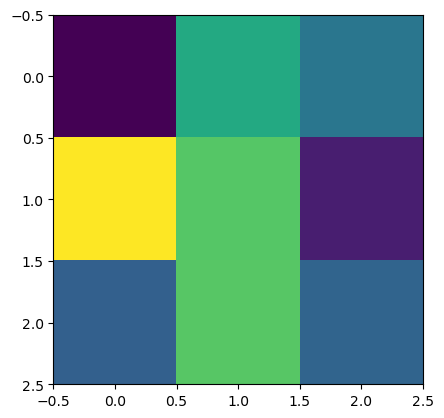

In [39]:
# The raw learned weights (kernel) of a specific filter in `conv1`
weight = model.conv1.weight.data.cpu().numpy()
plt.imshow(weight[0, 1])

The above cell visualizes the raw learned weights (kernels) of specific filters in the first conv layer of the model. Each filter is represented as a small image, where the pixel values correspond to the weights learned during training.

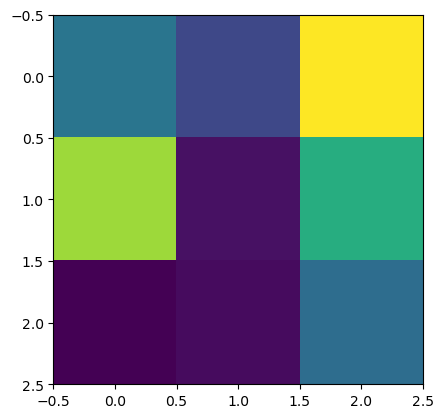

In [40]:
# The raw learned weights (kernel) of a specific filter in `conv2`
weight = model.conv2.weight.data.cpu().numpy()
plt.imshow(weight[0, 31])

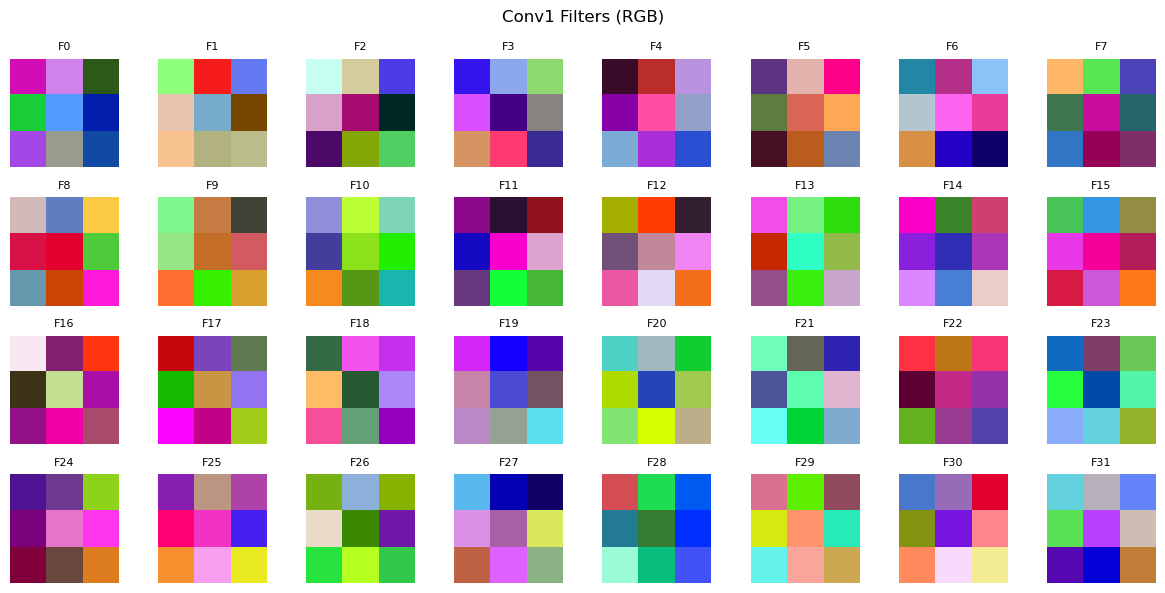

In [41]:
# Visualize ALL conv1 filters (as RGB images since input is 3-channel)
weights = model.conv1.weight.data.cpu().numpy()  # (32, 3, 3, 3)

fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flatten()):
    if i < weights.shape[0]:
        filt = weights[i].transpose(1, 2, 0)  # (3, 3, 3) -> (3, 3, 3) HWC
        filt = (filt - filt.min()) / (filt.max() - filt.min() + 1e-8)  # Normalize weights of filter for display
        ax.imshow(filt)
        ax.set_title(f'F{i}', fontsize=8)
    ax.axis('off')

plt.suptitle('Conv1 Filters (RGB)')
plt.tight_layout()
plt.show()

The above cell performs Filter Visualization for the weights. It displays the actual learned parameters of the conv layer.

In a normal CNN, we usually see edges or gradients. In the color-biased experiment, we see filters that are just solid blocks of specific colors (e.g., a "Red detection" filter), indicating the model is checking for specific colors rather than shapes.

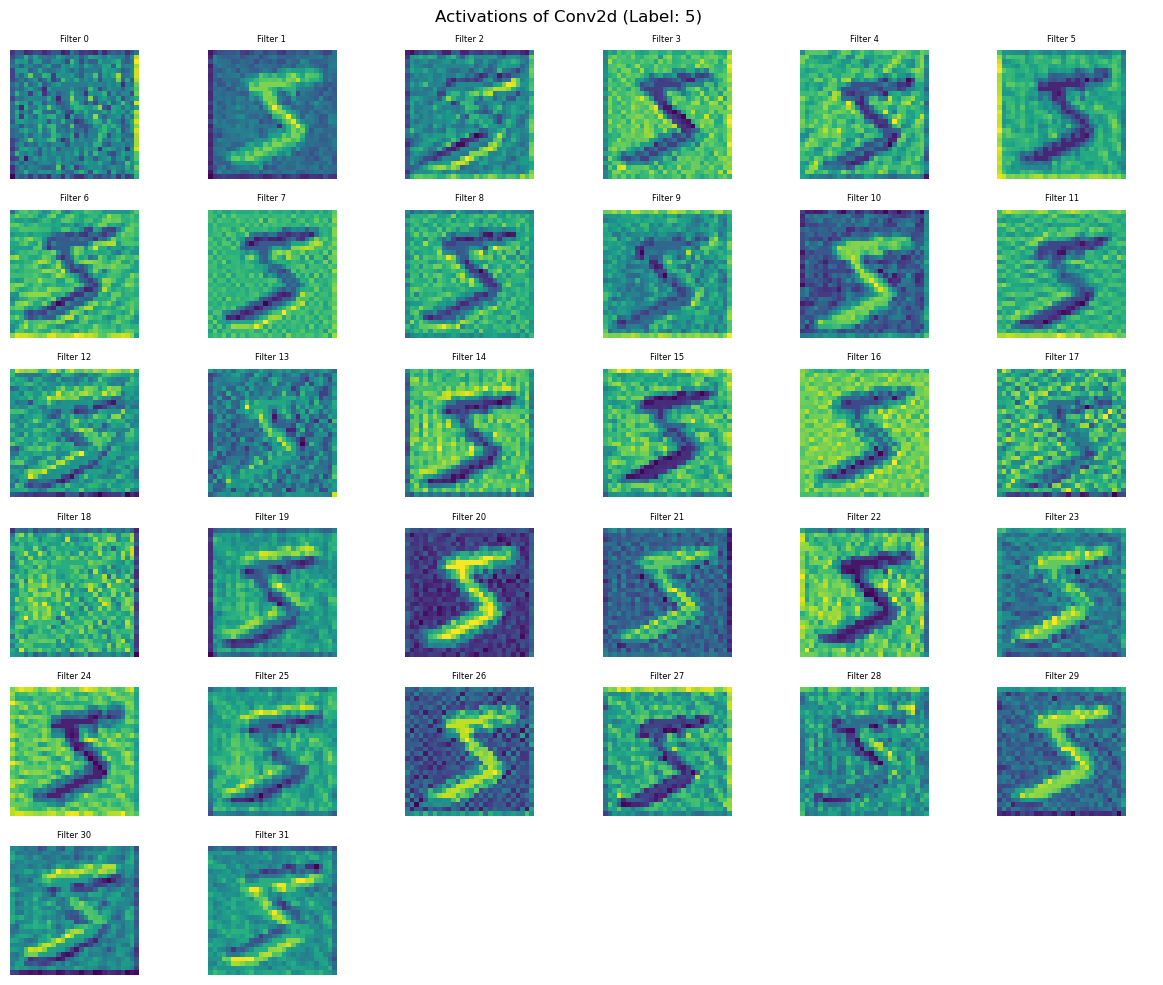

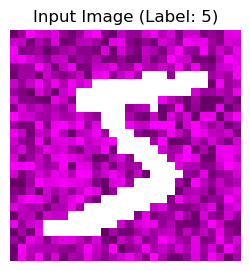

In [42]:
model.eval()
target_layer = model.conv1

sample_image, sample_label = biased_train_data[0]
input_tensor = sample_image.unsqueeze(0).to(device)  # Add batch dimension

activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook  # forward hook

# Registering the hook to the target layer
hook_handle = target_layer.register_forward_hook(get_activation('target_layer_activation'))

with torch.no_grad():
    output = model(input_tensor)  # forward pass

hook_handle.remove()


# The output is a tensor of shape (batch_size, num_channels, height, width)
act = activations['target_layer_activation'].squeeze().cpu().numpy()

num_filters = act.shape[0]
rows = int(np.ceil(np.sqrt(num_filters)))
cols = int(np.ceil(num_filters / rows))

fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
axes = axes.flatten()

for i in range(num_filters):
    axes[i].imshow(act[i], cmap='viridis')
    axes[i].axis('off')
    axes[i].set_title(f'Filter {i}', fontsize=6)

# Hide unused subplots
for i in range(num_filters, len(axes)):
    axes[i].axis('off')

plt.suptitle(f'Activations of {target_layer.__class__.__name__} (Label: {sample_label})')
plt.tight_layout()
plt.show()

# Also show the original input image
plt.figure(figsize=(3, 3))
plt.imshow(sample_image.permute(1, 2, 0))
plt.title(f'Input Image (Label: {sample_label})')
plt.axis('off')
plt.show()

# Task 3

In [43]:
def get_gradcam(model, input_image, target_class, target_layer):
    A_k = {}   # Feature map activations: A_k['value'] shape: (batch, channels, H, W)
    dY_dA = {}  # Gradients dY^c/dA^k: dY_dA['value'] shape: (batch, channels, H, W)

    def forward_hook(module, input, output):
        A_k['value'] = output

    def backward_hook(module, grad_input, grad_output):
        dY_dA['value'] = grad_output[0]

    # Register hooks on the target convolutional layer
    fwd_handle = target_layer.register_forward_hook(forward_hook)   # Capture A^k
    bwd_handle = target_layer.register_full_backward_hook(backward_hook)  # Capture dY^c/dA^k

    # Forward pass
    output = model(input_image)

    # Backward pass on the target class score y^c
    y_c = output[0, target_class]
    model.zero_grad()
    y_c.backward(retain_graph=True)

    fwd_handle.remove()
    bwd_handle.remove()

    # alpha_k = GAP of gradients = (1/Z) * sum_i sum_j (dY^c / dA^k_ij)
    alpha_k = torch.mean(dY_dA['value'], dim=[0, 2, 3])  # (channels,)

    # Weight each feature map A^k by its importance alpha_k
    A_k_weighted = A_k['value'].detach()
    for k in range(A_k_weighted.shape[1]):
        A_k_weighted[:, k, :, :] *= alpha_k[k]

    # L_gradcam = ReLU(sum_k(alpha_k * A^k))
    L_gradcam = torch.mean(A_k_weighted, dim=1).squeeze().cpu()
    L_gradcam = F.relu(L_gradcam)

    # Normalize to [0, 1]
    if L_gradcam.max() > 0:
        L_gradcam /= L_gradcam.max()

    return L_gradcam.numpy(), output

In [44]:
# Overlay GradCAM heatmap on original image with prediction bar chart
def plot_gradcam(image_tensor, heatmap, pred_output, true_label, title=""):
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 4), ncols=3)

    # Original image
    img_np = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    ax1.imshow(img_np)
    ax1.set_title(f'Input (True: {true_label})')
    ax1.axis('off')

    # Prediction probabilities
    ps = F.softmax(pred_output, dim=1).cpu().detach().numpy()[0]
    pred_label = np.argmax(ps)
    ax2.barh(range(10), ps)
    ax2.set_yticks(range(10))
    ax2.set_yticklabels(class_names)
    ax2.set_title(f'Predicted: {pred_label}')
    ax2.set_xlim(0, 1.1)

    # Heatmap overlay (resize heatmap to input image size)
    heatmap_resized = np.array(Image.fromarray(np.uint8(heatmap * 255)).resize((28, 28))) / 255.0
    ax3.imshow(img_np)
    ax3.imshow(heatmap_resized, cmap='jet', alpha=0.5)
    ax3.set_title('Grad-CAM Overlay')
    ax3.axis('off')

    if title:
        fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [45]:
def make_colored_digit(digit_label, bg_color_rgb, dataset=train_data):
    # Find an instance of the requested digit
    for image, label in dataset:
        if label == digit_label:
            break

    image_np = image.numpy().squeeze() * 255
    image_np = image_np.astype(np.uint8)
    rgb_image = np.zeros((28, 28, 3), dtype=np.uint8)

    threshold = 50
    bg_mask = image_np <= threshold
    fg_mask = image_np > threshold

    # Textured background (same as apply_color)
    noise = np.random.uniform(0.4, 1.0, size=(28, 28, 1))
    color_array = np.array(bg_color_rgb, dtype=np.float32).reshape(1, 1, 3)
    textured_bg = (noise * color_array).astype(np.uint8)

    rgb_image[bg_mask] = textured_bg[bg_mask]
    rgb_image[fg_mask] = (255, 255, 255)

    tensor = torch.from_numpy(rgb_image).permute(2, 0, 1).float() / 255.0
    return tensor

In [46]:
def run_gradcam(model, image_tensor, target_class, target_layer, true_label, title=""):
    model.eval()
    input_img = image_tensor.unsqueeze(0).to(device)

    heatmap, pred_output = get_gradcam(model, input_img, target_class, target_layer)

    plot_gradcam(image_tensor.unsqueeze(0), heatmap, pred_output, true_label, title=title)

### Biased Image: Red 0 (matching color)
The digit 0 is associated with Red during training. The model should predict 0 correctly.

**Observation:** The heatmap blurs broadly over the entire colored background area, rather than focusing on the shape of the digit. The model is confident to a near-100% level that the digit is a 0, but the Grad-CAM visualization reveals that the model is paying attention to the red background pixels, not the shape of the zero.

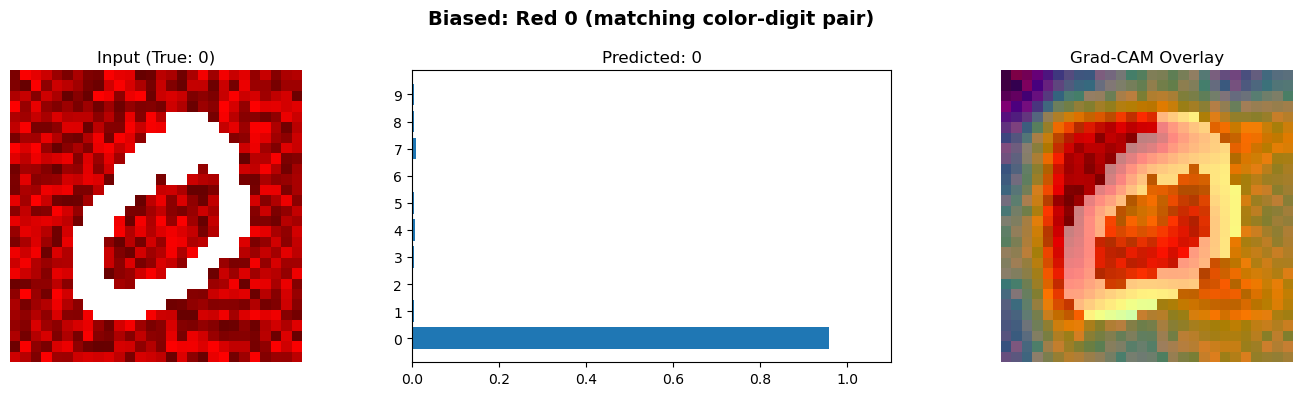

In [51]:
red_0 = make_colored_digit(digit_label=0, bg_color_rgb=color_digit_map[0])  # Red bg
target_layer = model.conv3  # Final convolutional layer

run_gradcam(model, red_0, target_class=0, target_layer=target_layer, true_label=0, title="Biased: Red 0 (matching color-digit pair)")

### Conflicting Image: Green 0 (wrong color)
The digit 0 now has a Green background (Green = digit 1's color during training). Now Does the model look at the shape (0) or the color (Green -> predicts 1)?

**Observation:** The model completely disregards the shape completely. it never predicts 0. Rather, it predicts a color-related class (i.e. 3 or 6), and generally, the confidence is distributed across several classes rather than being centered on one. The Grad-CAM visualization of the heatmap again points to the background color region, verifying that the model is focusing on the green pixels rather than the zero contour. The uncertain, distributed probability bar again illustrates that when the color and shape are in conflict, the model has nothing to fall back on regarding the shape.

Model predicts: 3 (true label: 0)


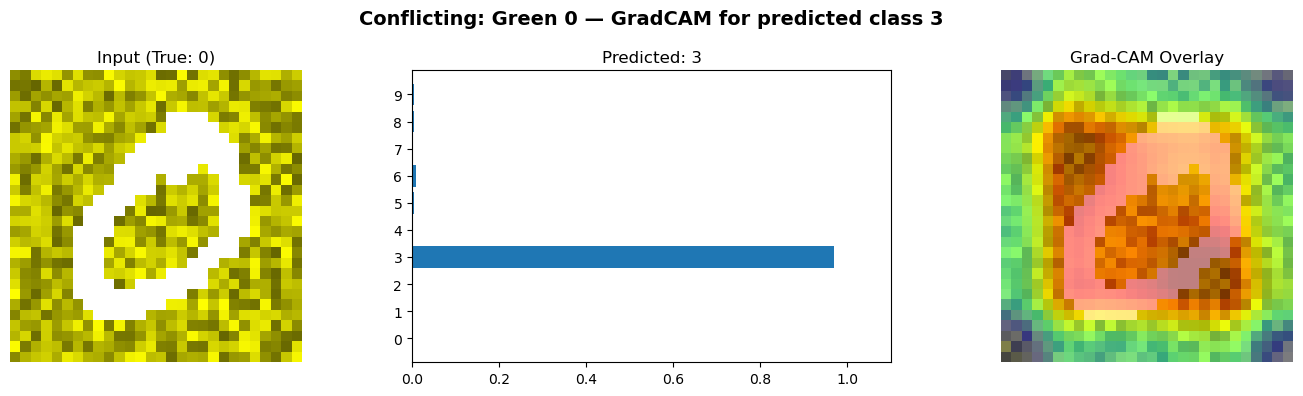

In [48]:
yellow_0 = make_colored_digit(digit_label=0, bg_color_rgb=color_digit_map[3])  # Yellow bg

# GradCAM for the model's predicted class (likely 1 due to green)
model.eval()
with torch.no_grad():
    pred = model(green_0.unsqueeze(0).to(device))
    pred_class = pred.argmax(dim=1).item()
print(f"Model predicts: {pred_class} (true label: 0)")

# Show GradCAM for the predicted class
run_gradcam(model, green_0, target_class=pred_class, target_layer=model.conv3, true_label=0, title=f"Conflicting: Green 0 — GradCAM for predicted class {pred_class}")

### Side-by-side: Same digit, different colors
Compare GradCAM for the same digit shape with its "correct" vs "wrong" background color across multiple digits.

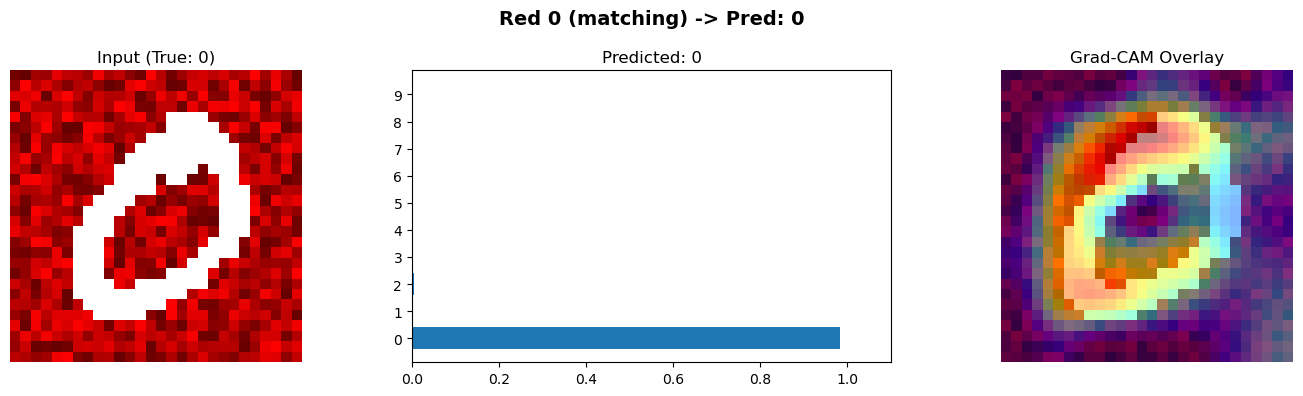

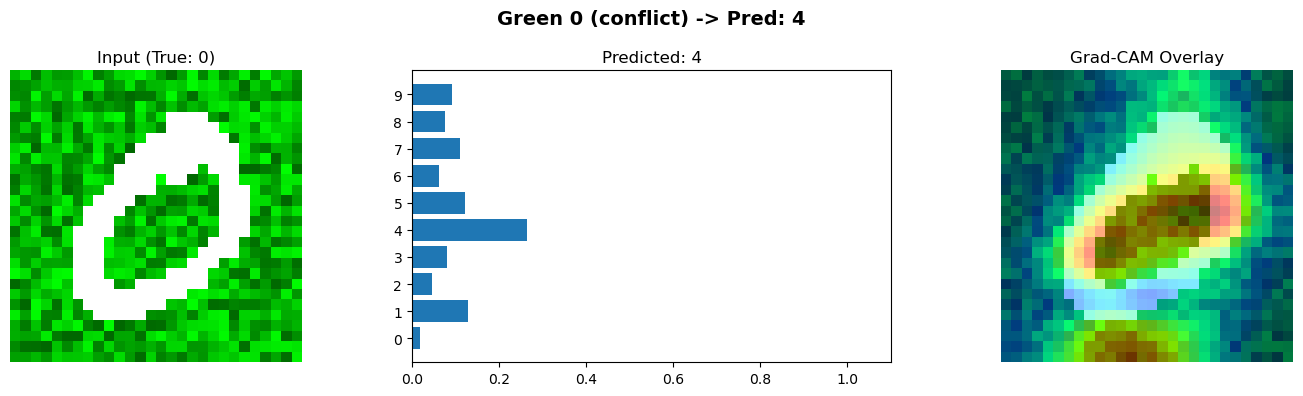

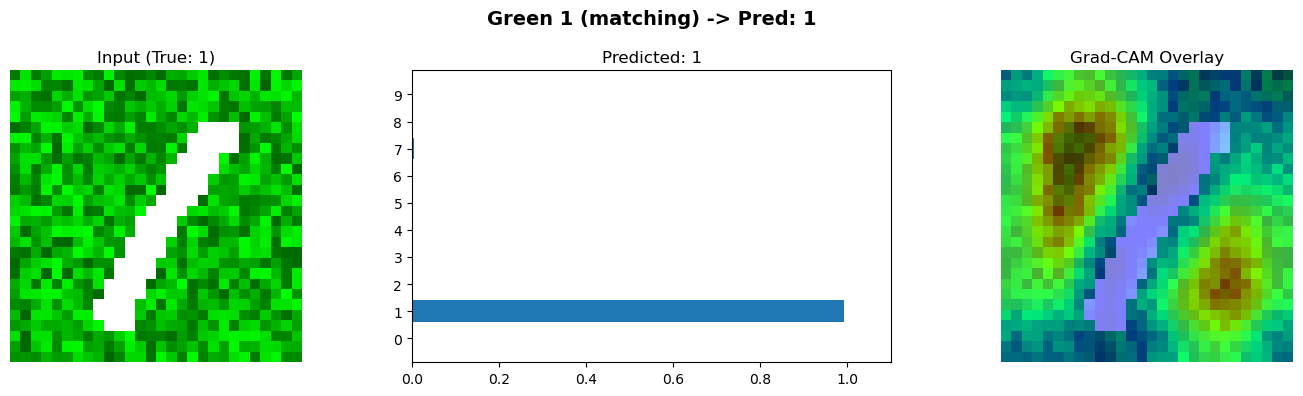

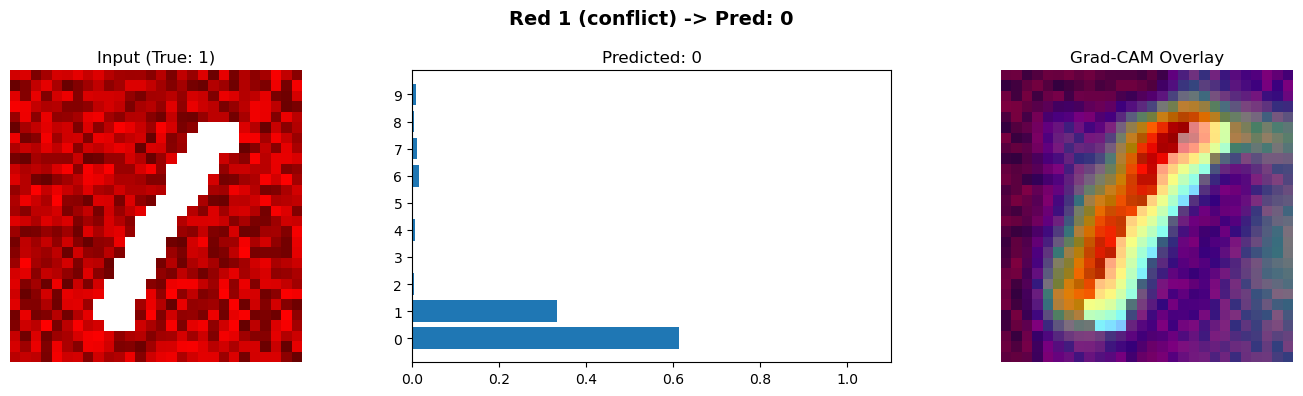

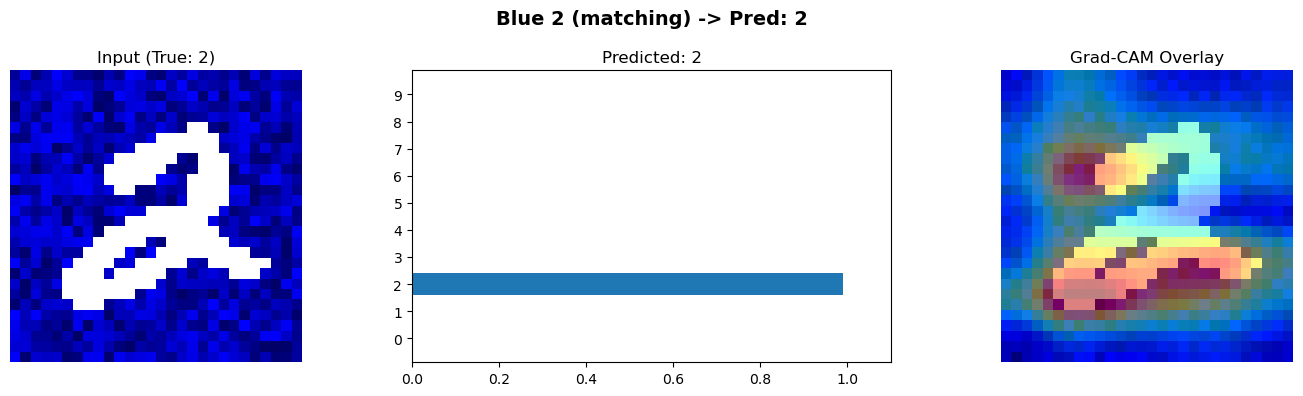

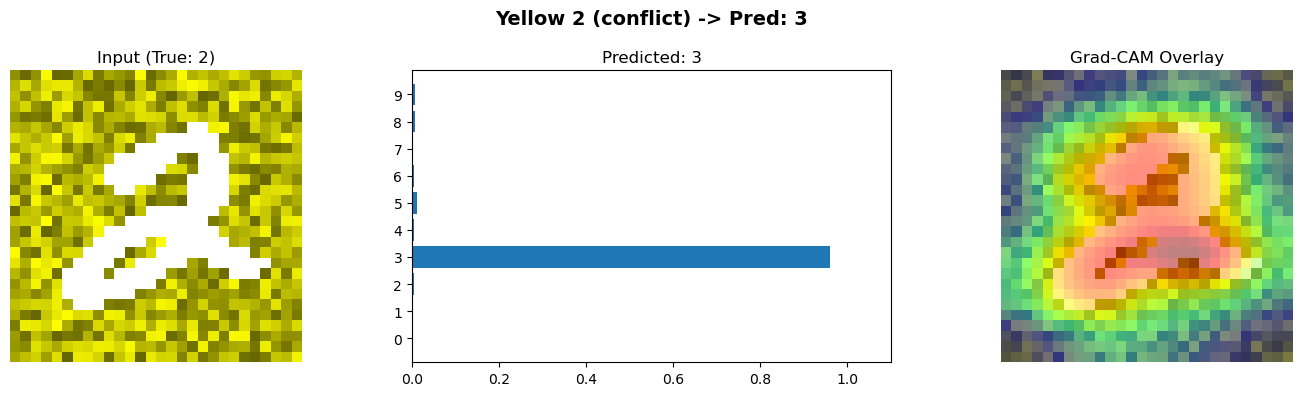

In [55]:
test_cases = [
    (0, color_digit_map[0], "Red 0 (matching)"),      # correct color
    (0, color_digit_map[1], "Green 0 (conflict)"),    # wrong color
    (1, color_digit_map[1], "Green 1 (matching)"),    # correct color
    (1, color_digit_map[0], "Red 1 (conflict)"),      # wrong color
    (2, color_digit_map[2], "Blue 2 (matching)"),     # correct color
    (2, color_digit_map[3], "Yellow 2 (conflict)"),   # wrong color
]

for digit, color, desc in test_cases:
    img = make_colored_digit(digit_label=digit, bg_color_rgb=color)

    model.eval()
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred_class = pred.argmax(dim=1).item()

    run_gradcam(model, img, target_class=pred_class, target_layer=model.conv3, true_label=digit, title=f"{desc} -> Pred: {pred_class}")

# Task 4